In [1]:
import os
from solardatatools import DataHandler
import pandas as pd
import boto3
from dask import delayed, compute, config
from dask.distributed import Client, LocalCluster, performance_report
import json
import click
import tempfile
import csv

In [2]:
def s3_csv_to_dh(path):
    """
    Converts a s3 CSV file into a solar-data-tools DataHandler.
    Parameters:
    - file: Path to the CSV file.
    Returns:
    - A tuple of the file name and its corresponding DataHandler.
    """
    df = pd.read_csv(path, index_col=0)
    # Convert index from int to datetime object
    df.index = pd.to_datetime(df.index)
    dh = DataHandler(df)
    name = path.split('/')[-1].removesuffix('.csv')
    return (name, dh)


def get_csvs_in_s3(s3, bucket, prefix):
    """
    Gets the csvs in an s3 directory.
    Parameters:
    - s3: Boto3 s3 client
    - bucket: Bucket containing the csvs.
    - prefix: Prefix appended to the bucket name when searching for files
    Returns:
    - An array of the csv file paths.
    """
    csvs = []
    data_bucket = s3.Bucket(bucket)
    for object_summary in data_bucket.objects.filter(Prefix=prefix):
        if object_summary.key.endswith('.csv'):
            file = f"s3://{bucket}/{object_summary.key}"
            csvs.append(file)
    return csvs


def local_csv_to_dh(file):
    """
    Converts a local CSV file into a solar-data-tools DataHandler.
    Parameters:
    - file: Path to the CSV file.
    Returns:
    - A tuple of the file name and its corresponding DataHandler.
    """
    df = pd.read_csv(file, index_col=0)
    # Convert index from int to datetime object
    df.index = pd.to_datetime(df.index)
    dh = DataHandler(df)
    name = os.path.basename(file)
    return (name, dh)


def get_csvs_in_dir(folder_path):
    """
    Gets the csvs in a directory.
    Parameters:
    - folder_path: Directory containing the csvs.
    Returns:
    - An array of the csv file paths.
    """
    csvs = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            if filename.endswith('.csv'):
                csvs.append(file_path)
    return csvs

def run_job(data_result, track_times):
    """
    Processes a single unit of data using DataHandler.
    Parameters:
    - data_result: Tuple of the file name and its corresponding DataHandler.
    - track_times: Boolean to determine whether run times are added to the 
                   output.
    Returns:
    - A dictionary containing the name of the data and the processed report.
    If there was an error with processing, only the name of the data is 
    returned.
    """
    name = data_result[0]
    data_handler = data_result[1]

    
    
    try:    
        data_handler.run_pipeline()
        report = data_handler.report(verbose=False, return_values=True)
        report["name"] = name
        if track_times:
            report["total_time"] = data_handler.total_time
    except:
        report = {}
        report["name"] = name
    return report

In [3]:
def generate_task_local(filename, track_times=True):
    """
    Generate the analysis task for a given local file. 
    
    Parameters:
    - filename: Name of the local file
    - track_times: Booleans to determine whether run times are added 
    to the output

    Returns:
    - A Dask delayed task object for the data analysis, which depends
    on the ingest task. 
    """
    task_ingest = delayed(local_csv_to_dh)(filename)
    task_analyze = delayed(run_job)(task_ingest, track_times)
    return task_analyze

In [4]:
def generate_tasks_directory(directory, track_times=True):
    """
    Generate the analysis tasks for a given directory containing csv's. 
    
    Parameters:
    - directory: Path of the directory containing csv's
    - track_times: Booleans to determine whether run times are added 
    to the output

    Returns:
    - A list of Dask delayed task objects for the data analysis, 
    each of which depends on an ingest task. 
    """
    result = []
    for filename in get_csvs_in_dir(directory):
        if "log.csv" not in filename:
            result.append(generate_task_local(filename))
    return result

In [5]:
def write_reports(reports, filename):
    if filename != "":
        #logs = client.get_worker_logs()
        with open(filename, "w") as fp:
            writer = csv.writer(fp)
            header = []
            for key in reports[0].keys():
                header.append(key)
            writer.writerow(header)
            for r in reports:
                writer.writerow(r.values())

# Visualize task graphs

In [6]:
obj_list = generate_tasks_directory("./")
aggregate_reports_task = delayed(write_reports)(obj_list, "log.csv")

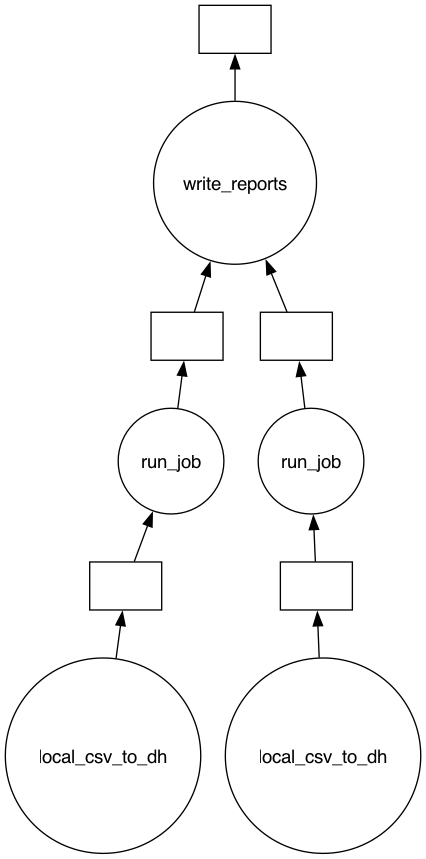

In [7]:
aggregate_reports_task.visualize()

# Execute Task Graph

In [8]:
def execute_tasks(task_list):
    """
    Execute a list of tasks. 
    
    NOTE: The Dask cluster should be 
    intialized before calling this function. 
    
    Parameters:
    - task_list: A list of dask delayed object

    Returns:
    - A list of reports from execution
    """
    reports = compute(*task_list,)
    return reports

In [9]:
client = Client(threads_per_worker=4, n_workers=2)

#reports = execute_tasks(obj_list)
compute(aggregate_reports_task)


(None,)

In [10]:
client.shutdown()

total time: 19.06 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              0.81s
Cleaning                   0.04s
Filtering/Summarizing      18.21s
    Data quality           0.04s
    Clear day detect       0.05s
    Clipping detect        17.08s
    Capacity change detect 1.03s

total time: 19.06 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              0.83s
Cleaning                   0.04s
Filtering/Summarizing      18.19s
    Data quality           0.04s
    Clear day detect       0.06s
    Clipping detect        17.07s
    Capacity change detect 1.02s



In [11]:
# TODO: we need functions to generate tasks from remote sources


# each node is a row in the record
# identifier for that file


2023-12-08 20:04:26,638 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [ ]:
def remote_file_to_dh(file):
    """
    Converts a file of remote database site into a list solar-data-tools DataHandler.
    Parameters:
    - file: remote sites of database.
    Returns:
    - A list of tuples of the unique identifier and its corresponding DataHandler.
    """
    result = []
    for site in file:
        df = load_cassandra_data(site)
        dh = DataHandler(df, convert_to_ts=True)
        dh.data_frame_raw.index = dh.data_frame_raw.index.view("int")
        dh_keys = dh.keys
        for key in dh_keys:
            system = key[0][1]
            system = system.strip()
            result.append((system, dh))
    return result

In [ ]:
def generate_task_remote(file, track_times=True):
    """
    Generate the analysis task for a given system.

    Parameters:
    - system: Name of the system
    - track_times: Booleans to determine whether run times are added
    to the output

    Returns:
    - A Dask delayed task object for the data analysis, which depends
    on the ingest task.
    """
    task_analyze = []
    task_ingest = remote_file_to_dh(file)
    for task in task_ingest:
        task_analyze.append(delayed(run_job)(task, track_times))
    return task_analyze


In [ ]:
def generate_tasks_remote_database(db_list):
    """
    Generate the analysis tasks for remote database.

    Parameters:
    - db_list: Path of the directory containing a list of sites from remote database

    Returns:
    - A list of Dask delayed task objects for the data analysis,
    each of which depends on an ingest task.
    """
    result = []
    with open(db_list, "r") as file:
        result.extend(generate_task_remote(file))
    return result

In [ ]:
db_list = ""
obj_list = generate_tasks_remote_database(db_list)
obj_list